In [1]:
import os 
import re 
import json
import random
from tqdm.notebook import tqdm

In [2]:
import rutokenizer
from nltk import sent_tokenize

In [3]:
# изначально данные разбросаны по нескольким json файлам
court_files = [fi for fi in list(os.listdir()) if fi.endswith('json')]

In [9]:
data_dict = {}

for json_file in court_files:
    with open(json_file, encoding='utf-8') as f:
        data_dict_one = json.load(f)
    data_dict.update(data_dict_one)

print(len(data_dict))

21893


In [10]:
# полный текст некоторых постановлений не скачался: уберем такие вхождения
data_dict = {index:data_dict[index] for index in data_dict if data_dict[index]['text']!=''}

print(len(data_dict))

19859


Функции для чистки полных текстов и аннотаций. После всех операций данные представляют собой связный текст

In [26]:
demand_phrases = ('Рассматривается дело o', 'Заявляется требование o')

def prepare_summary(text, demand_phrases=demand_phrases):
    text = re.sub('\n', ' ', text)
    preprocessed_text = re.sub('[0-9]\)','', text)
    preprocessed_text = preprocessed_text.replace('Требование: О', random.choice(demand_phrases))
    preprocessed_text = preprocessed_text.replace('Требование:  О', random.choice(demand_phrases))
    preprocessed_text = preprocessed_text.replace('Встречное требование: О', 
                                                  'Получено встречное требование о')
    preprocessed_text = preprocessed_text.replace('Решение:','')
    preprocessed_text = preprocessed_text.replace('Обстоятельства:','')
    return preprocessed_text

In [27]:
def prepare_full_text(text):
    start_index = re.search('\n\nустановил:\n\n|\n\nпостановил:\n\n', text).end()
    text = text[start_index:]
    last_sentence = sent_tokenize(text)[-1]
    preprocessed = text.replace(last_sentence, '')
    preprocessed = re.sub('\(.*?\)', '', preprocessed)
    return preprocessed

In [35]:
not_judgements_ids = []

for id in tqdm(data_dict.keys()):
    try:
        data_dict[id]['summary'] = prepare_summary(data_dict[id]['summary'])
        data_dict[id]['text'] = prepare_full_text(data_dict[id]['text'])
    except AttributeError:
        not_judgements_ids.append(id)

Сохранили отдельно id документов, не являющихся постановлениями (не содержит ключевую фразу *(суд) установил*). Удалим их

In [39]:
for id_to_del in not_judgements_ids:
    print(data_dict[id_to_del]['title'])
    data_dict.pop(id_to_del)

Протокол заседания Научно-консультативного совета при Арбитражном суде Московского округа от 27 ноября 2020 г. N 20


In [40]:
import rutokenizer

t = rutokenizer.Tokenizer()
t.load()

Функции для токенизации и получения биграмм:

In [41]:
from string import punctuation

punkt = punctuation + '«»—…“”*№–'

def get_tokens(text):
    return [x for x in t.tokenize(text)if x not in punkt]

def ngrams(tokens, n=2):
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]   

Полный цикл подсчета количества предложений, токенов, пересечений биграмм в каждой паре текст-аннотация:

In [42]:
with_short_summ_ids = []

txt_sents_counts, sum_sents_counts = [], []
txt_words_counts, sum_words_counts = [], []
common_bigrams_parts = []

for id in tqdm(data_dict.keys()):
    text = data_dict[id]["text"]
    summary = data_dict[id]["summary"]
    
    words = get_tokens(text)
    sum_words = get_tokens(summary)
    
    if len(sum_words)<30 or len(sent_tokenize(summary))==1:
        with_short_summ_ids.append(id)
        continue
                                                             
    txt_sents_counts.append(len(sent_tokenize(text)))
    sum_sents_counts.append(len(sent_tokenize(summary)))

    txt_words_counts.append(len(words))
    sum_words_counts.append(len(sum_words))
    
    txt_bigrams =  set(ngrams(words))
    sum_bigrams = set(ngrams(sum_words))
    
    bigram_inter = txt_bigrams.intersection(sum_bigrams)
    common_bigrams_parts.append(len(bigram_inter)/len(sum_bigrams))

In [43]:
print('Текстов со слишком короткими аннотациями: ', len(with_short_summ_ids))

Текстов со слишком короткими аннотациями:  1967


Уберем их из рассмотрения

In [44]:
for id_to_del in with_short_summ_ids:
    data_dict.pop(id_to_del)

len(data_dict)

17891

In [45]:
print('-------------СТАТИСТИКА ПО ПРЕДЛОЖЕНИЯМ-------------')
print('Среднее количество предложений в документах:', sum(txt_sents_counts)/len(txt_sents_counts))
print('Минимальное количество предложений в документах:', min(txt_sents_counts))
print('Максимальное количество предложений в документах:', max(txt_sents_counts))
print('\n')
print('Среднее количество предложений в аннотациях:', sum(sum_sents_counts)/len(sum_sents_counts))
print('Минимальное количество предложений в аннотациях:', min(sum_sents_counts))
print('Максимальное количество предложений в аннотациях:', max(sum_sents_counts))

-------------СТАТИСТИКА ПО ПРЕДЛОЖЕНИЯМ-------------
Среднее количество предложений в документах: 46.70482365435135
Минимальное количество предложений в документах: 11
Максимальное количество предложений в документах: 640


Среднее количество предложений в аннотациях: 3.219663517969929
Минимальное количество предложений в аннотациях: 2
Максимальное количество предложений в аннотациях: 11


In [46]:
print('-------------СТАТИСТИКА ПО ТОКЕНАМ-------------')
print('Среднее количество токенов в документах:', sum(txt_words_counts)/len(txt_words_counts))
print('Минимальное количество токенов в документах:', min(txt_words_counts))
print('Максимальное количество токенов в документах:', max(txt_words_counts))
print('\n')
print('Среднее количество токенов в аннотациях:', sum(sum_words_counts)/len(sum_words_counts))
print('Минимальное количество токенов в аннотациях:', min(sum_words_counts))
print('Максимальное количество токенов в аннотациях:', max(sum_words_counts))

-------------СТАТИСТИКА ПО ТОКЕНАМ-------------
Среднее количество токенов в документах: 1372.221843384942
Минимальное количество токенов в документах: 345
Максимальное количество токенов в документах: 15789


Среднее количество токенов в аннотациях: 60.35503884634733
Минимальное количество токенов в аннотациях: 30
Максимальное количество токенов в аннотациях: 107


In [47]:
print("Средний процент биграмм, общих для исходных текстов и аннотаций:", "{:.2f}%".format(sum(common_bigrams_parts)/len(common_bigrams_parts)*100))

Средний процент биграмм, общих для исходных текстов и аннотаций: 52.06%


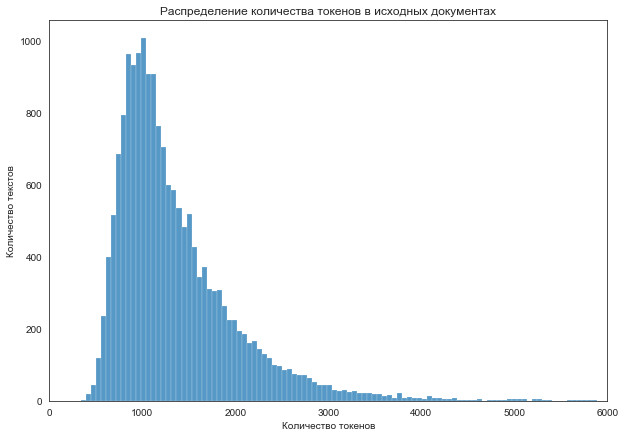

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
%matplotlib inline 


plt.figure(figsize=(10,7))
sns.histplot(txt_words_counts)
plt.title('Распределение количества токенов в исходных документах')
plt.xlabel('Количество токенов')
plt.ylabel('Количество текстов')
plt.xlim(0, 6000)
plt.savefig('text_tok_dictrib.png')
plt.show()

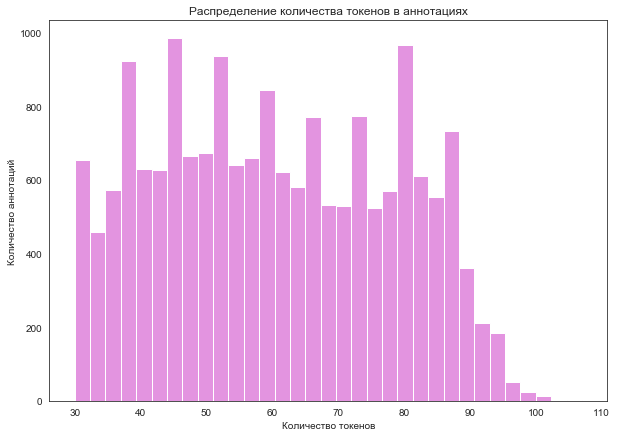

In [49]:
plt.figure(figsize=(10,7))
sns.histplot(sum_words_counts, color='orchid')
plt.title('Распределение количества токенов в аннотациях')
plt.xlabel('Количество токенов')
plt.ylabel('Количество аннотаций')
plt.savefig('sum_tok_dictrib.png')
plt.show()

Обращение к API сервиса http://ru.readability.io для подсчета индексов читаемости текста случайно выбранных 1000 документов

In [37]:
import requests
import random

thous_rand_docs = random.sample(data_dict.keys(), 1000)

fk_inds = []
ari_inds = []
fk_grades = []
ari_grades = []

for id in tqdm(thous_rand_docs):
    response = requests.post("http://api.plainrussian.ru/api/1.0/ru/measure/", data={"text":data_dict[id]['text']})
    response_dict = response.json()
    fk_inds.append(response_dict['indexes']['index_fk'])
    ari_inds.append(response_dict['indexes']['index_ari'])
    fk_grades.append(response_dict['indexes']['grade_fk'])
    ari_grades.append(response_dict['indexes']['grade_ari'])  

In [38]:
print('-------------ОЦЕНКА ЧИТАБЕЛЬНОСТИ-----------------')
print('Средний ARI: ', sum(ari_inds)/len(ari_inds))
print('Среднее значение индекса удобочитаемости Флеша: ', sum(fk_inds)/len(fk_inds))

-------------ОЦЕНКА ЧИТАБЕЛЬНОСТИ-----------------
Средний ARI:  19.816013269545028
Среднее значение индекса удобочитаемости Флеша:  19.6606810972382


In [39]:
from collections import Counter

print(Counter(ari_grades))
print(Counter(fk_grades))

Counter({'Аспирантура, второе высшее образование, phD': 897, '4 - 6 курсы ВУЗа (возраст примерно: 20-22 лет)': 101, '1 - 3 курсы ВУЗа (возраст примерно: 17-19 лет)': 2})
Counter({'Аспирантура, второе высшее образование, phD': 843, '4 - 6 курсы ВУЗа (возраст примерно: 20-22 лет)': 153, '1 - 3 курсы ВУЗа (возраст примерно: 17-19 лет)': 4})


Деление выборки на обучающую и тестовую, сохранение в файл:

In [50]:
from sklearn.model_selection import train_test_split

train_keys, test_keys = train_test_split(list(data_dict.keys()), test_size=0.15, random_state=10)

In [51]:
dict_train, dict_test = {}, {}

for k in train_keys:
    dict_train[k] = data_dict[k]

for k in test_keys:
    dict_test[k] = data_dict[k]

In [52]:
print('Train :', len(dict_train))
print('Test: ', len(dict_test))

Train : 15207
Test:  2684


In [53]:
with open('judgements_train.json', 'w', encoding='utf-8') as f:
    json.dump(dict_train, f, ensure_ascii=False)

In [55]:
with open('judgements_test.json', 'w', encoding='utf-8') as f:
    json.dump(dict_test, f, ensure_ascii=False)